In [1]:
# AMP decoder for signal recovery in compressed sensing (CS) for images.
# Due to the high-dimensionality of images, I use a subsampled discrete 
# cosine transform (DCT) sensing matrix and the DCT fast transform to reduce 
# computational complexity.
#
# CS model: y = Ax + noise where x is the flattened image.
# Goal: recover x given y and A
#
# Note:
# Usually in compressed imaging one considers images that is sparse in linear 
# transform, i.e., x = Bc, where c is a sparse coefficient vector and B is a 
# linear transform matrix e.g. discrete cosine transform or wavelet 
# transform. This results in the compressed imaging model y = (AB)c + noise.
#
# In this notebook I do not consider the full compressed imaging model just 
# described. Instead I simply consider the usual CS model y = Ax + noise and 
# let x be the sparse DCT coefficients of an image. The goal is simply to
# reconstruct the coefficients x from measurements y. With real images, the
# DCT coefficients are not sparse (none of its entries are zero), but can be
# considered approximately sparse (a small number of coefficients contains 
# the bulk of the image's energy).
#
# Copyright (c) 2021 Kuan Hsieh

import time
import numpy as np
from numpy import linalg as LA
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.fftpack import dct, idct # DCT
from amp4cs import opt_tuning_param, soft_thresh, sub_dct

Text(0.5, 1.0, 'DCT coefficients (magnitude)')

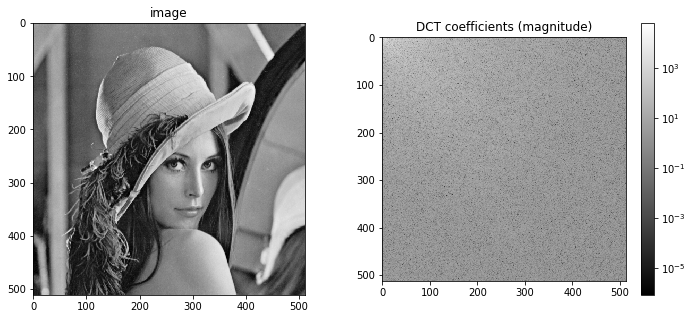

In [2]:
# Read in file
im      = matplotlib.image.imread('./lena_gray_512.tif')
im_coef = dct(dct(im.T, norm='ortho').T, norm='ortho') # 2D-DCT

# Plot image and the magnitude of its DCT coefficients
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.imshow(im, cmap='gray',interpolation=None)
plt.title('image')
plt.subplot(122)
plt.imshow(abs(im_coef),cmap='gray',interpolation=None,norm=LogNorm())
plt.colorbar(shrink=1.0)
plt.title('DCT coefficients (magnitude)')

In [3]:
# Set compressed imaging system parameters
delta     = 0.8 # Undersampling ratio
sigma     = 0   # Measurement noise standard deviation
eps_guess = 0.2 # Sparsity ratio guess (used to set the alpha parameter)
alpha     = opt_tuning_param(eps_guess)

# Measure (subsample) and add noise
x_init = im_coef.flatten() # 2D -> 1D array
N      = len(x_init)       # Dimension of signal
M      = round(N*delta)    # Number of measurements

# Use subsampled DCT matrix as sensing matrix
Ax, Az  = sub_dct(M, N, seed=np.random.randint(10000)) # Fast transforms
Ax_init = Ax(x_init)

# Add noise to measurements
noise = sigma*np.random.randn(M)
y     = Ax_init + noise

Text(0.5, 1.0, 'Reconstructed image \n iteration 0')

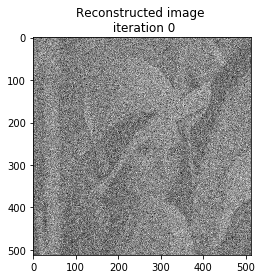

In [4]:
# Reconstruct image directly (zero pad the vector y and IDCT)
x_rec  = Az(y)
x_rec  = x_rec.reshape(im_coef.shape[0],im_coef.shape[1])  # 2D-DCT coefficients
im_rec = idct(idct(x_rec.T, norm='ortho').T, norm='ortho') # 2D-IDCT

plt.imshow(im_rec,cmap='gray',interpolation=None)
plt.title('Reconstructed image \n iteration 0')

time elapsed (s): 0.9131876560000194


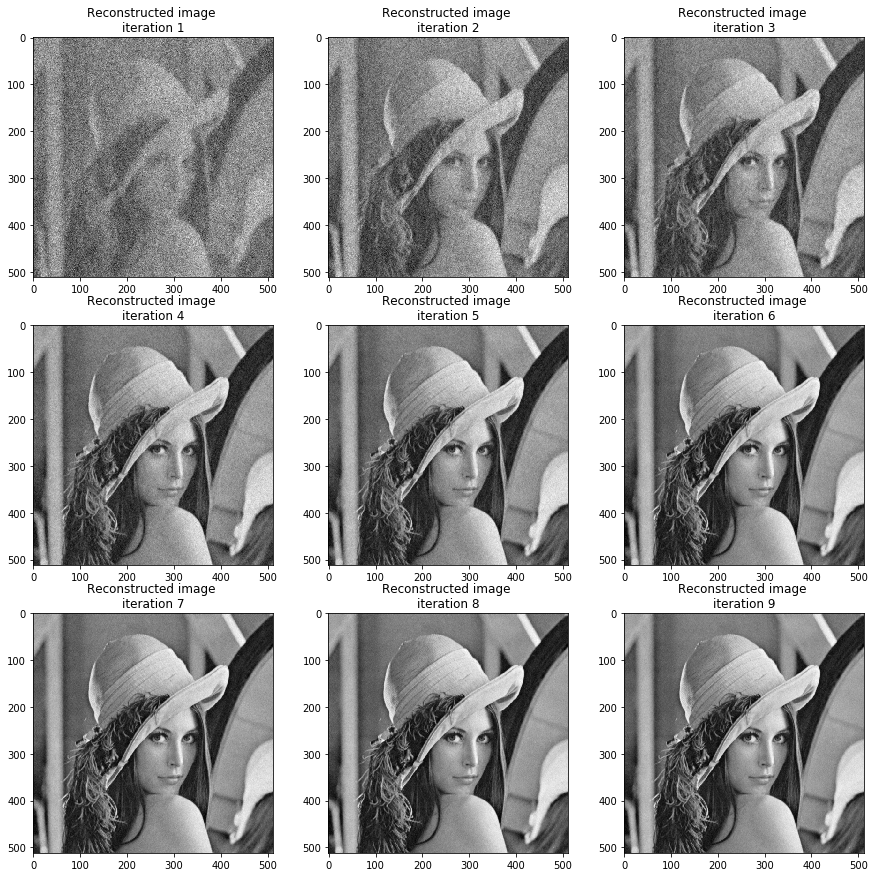

In [6]:
# Run AMP algorithm to recover compressed image

iter_max = 20 # Number of iterations

start = time.perf_counter()
x     = np.zeros_like(x_init) # Initial signal estimate
z     = y                     # Initial residual
mse   = np.ones(iter_max)*np.mean(x_init**2) # Store MSE
plt.figure(figsize=(15,15))

for t in range(iter_max-1):
    
    # Estimate vector
    theta = alpha*np.sqrt(LA.norm(z)**2/M) # alpha*tau
    x     = soft_thresh(x + Az(z), theta)
    mse[t+1] = np.mean((x-x_init)**2)
    
    # Calculate residual with the Onsager term
    b = LA.norm(x,0)/M
    z = y - Ax(x) + b*z
    
    if t < 9:
        x_rec  = x.reshape(im_coef.shape[0],im_coef.shape[1])
        im_rec = idct(idct(x_rec.T, norm='ortho').T, norm='ortho') # 2D-IDCT
        plt.subplot(3,3,t+1)
        plt.imshow(im_rec, cmap='gray',interpolation=None)
        plt.title('Reconstructed image \n'+'iteration '+str(t+1))

print("time elapsed (s):", time.perf_counter()-start) 

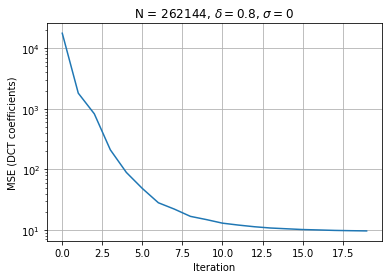

In [7]:
# Plot the MSE in the reconstructed DCT coefficients across iterations
plt.plot(mse)
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('MSE (DCT coefficients)')
plt.title('N = '+str(N)+r', $\delta=$'+str(delta)+r', $\sigma=$'+str(sigma))
plt.grid(True)
plt.show()